# 1. Import Libraries

In [130]:
# Saving and loading
import os

# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
import joblib

# Settings for visualisations
%matplotlib inline
sns.set(style="whitegrid")

# Suppress scientific notation for readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 2. Load Dataset

In [66]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("../data/stroke_data.csv")

# Show the first 5 rows
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


# 3. Basic Structure and Info About the Dataset

In [67]:
# Shape of the dataset (rows, columns)
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

# Data types and non-null values
df.info()

Rows: 5110
Columns: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# 4. Summary Statistics

In [68]:
# Summary statistics for numerical columns
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.00,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.10,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.00,0.00,77.25,23.50,0.00
50%,36932.00,45.00,0.00,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.00,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.00,1.00,271.74,97.60,1.00


In [69]:
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


### Conclusions from Summary Statistics

- The **minimum age is 0.08**, which suggests the dataset includes **infants (~1 month old)**. This may or may not be relevant depending on whether the study focus is on **adult stroke risk**.
- The **maximum BMI is 97.60**, which is an **extremely high value**. For context, BMI > 40 is classified as **morbid obesity**. This could be a valid extreme case, or a data entry error or outlier.

# 5. Check for Missing Values

In [70]:
# Total missing values per column
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [71]:
# Percentages of missing values
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

bmi                 3.93
id                  0.00
gender              0.00
age                 0.00
hypertension        0.00
heart_disease       0.00
ever_married        0.00
work_type           0.00
Residence_type      0.00
avg_glucose_level   0.00
smoking_status      0.00
stroke              0.00
dtype: float64

### Conclusions from Missing Values

- **BMI** has 201 missing values (3.93%). Since this is a relatively small percentage, we may consider imputing these missing values using the median or mean in later steps.

# 6. Univariate Analysis (Visualising Single Features)

### Figure 6a: Distribution of Gender in the Stroke Dataset (Categorical Data: Gender)

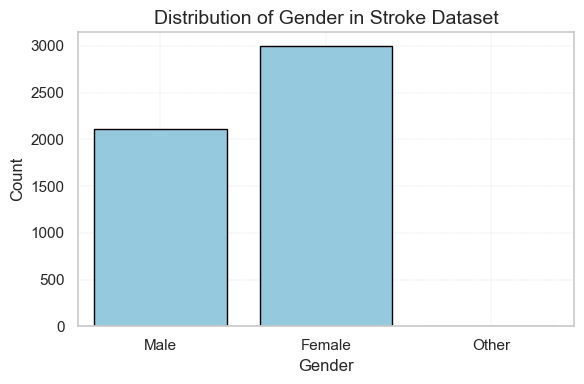

In [72]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender', color='skyblue', edgecolor='black')
plt.title('Distribution of Gender in Stroke Dataset', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 6b: Distribution of Age in the Stroke Dataset (Numerical Data: Age)

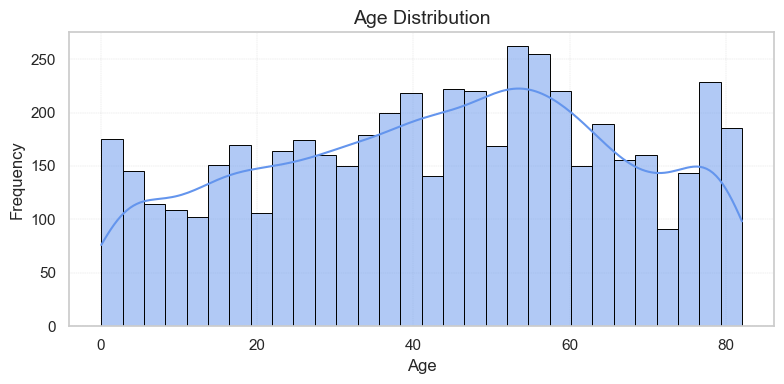

In [73]:
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], bins=30, kde=True, color='cornflowerblue', edgecolor='black', linewidth=0.7)
plt.title('Age Distribution', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 6c: Distribution by Marriage Status in the Stroke Dataset (Categorical Data: Ever Married?)

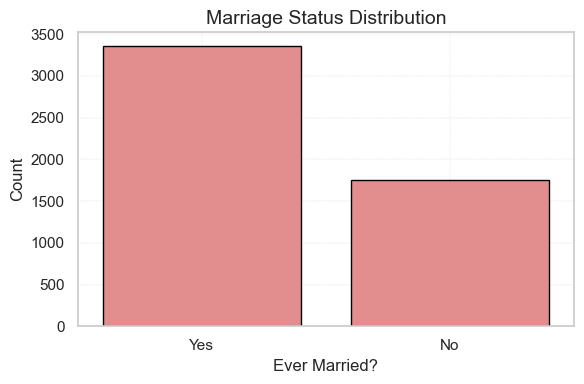

In [74]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='ever_married', color='lightcoral', edgecolor='black')
plt.title('Marriage Status Distribution', fontsize=14)
plt.xlabel('Ever Married?', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 6d: Distribution of BMI in the Stroke Dataset (Numerical Data: BMI)

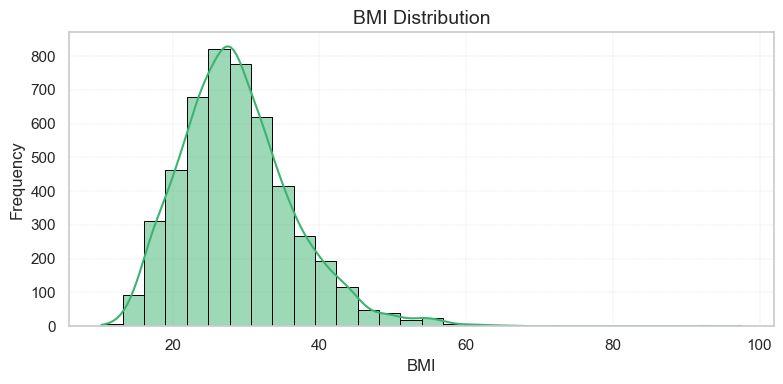

In [75]:
plt.figure(figsize=(8, 4))
sns.histplot(df['bmi'], bins=30, kde=True, color='mediumseagreen', edgecolor='black', linewidth=0.7)
plt.title('BMI Distribution', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions from Univariate Analysis

- There are **more females than males** in the dataset (approx. 3,000 vs 2,100), which may slightly skew gender-based conclusions.
- The **age distribution covers a wide range**, including **infants and children**, suggesting this dataset spans the full population.
- A **higher proportion of individuals are married**, which may correlate with age or lifestyle factors.
- **BMI appears normally distributed**, though with a slight **left skew**, and includes some extreme high values.

# 7. Bivariate Analysis — Feature vs Stroke

### Figure 7a: Stroke Occurrance by Gender (categorical vs categorical)

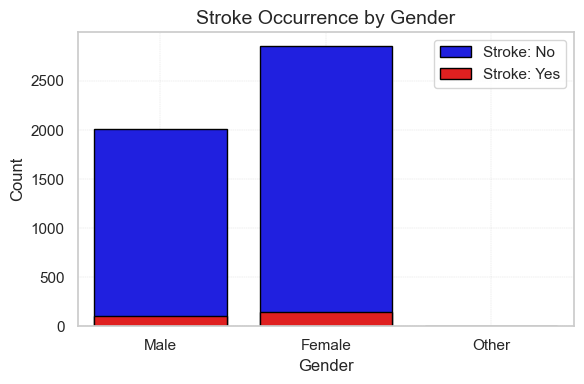

In [76]:
plt.figure(figsize=(6, 4))

# Barplot for Stroke = No
sns.countplot(
    data=df[df['stroke'] == 0],
    x='gender',
    color='blue',
    edgecolor='black',
    label='Stroke: No'
)

# Barplot for Stroke = Yes
sns.countplot(
    data=df[df['stroke'] == 1],
    x='gender',
    color='red',
    edgecolor='black',
    label='Stroke: Yes'
)

plt.title('Stroke Occurrence by Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

### Figure 7b: Stroke Occurrance by Age (continuous vs categorical)

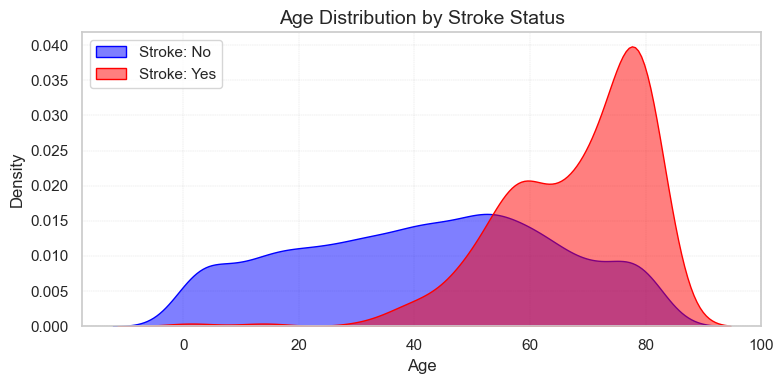

In [77]:
plt.figure(figsize=(8, 4))

# Colours: No stroke = gray, Yes stroke = crimson
sns.kdeplot(
    data=df[df['stroke'] == 0], x='age', fill=True, alpha=0.5, label='Stroke: No', color='blue'
)
sns.kdeplot(
    data=df[df['stroke'] == 1], x='age', fill=True, alpha=0.5, label='Stroke: Yes', color='red'
)

plt.title('Age Distribution by Stroke Status', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

### Figure 7c: Stroke Occurrance by BMI (continuous vs categorical)

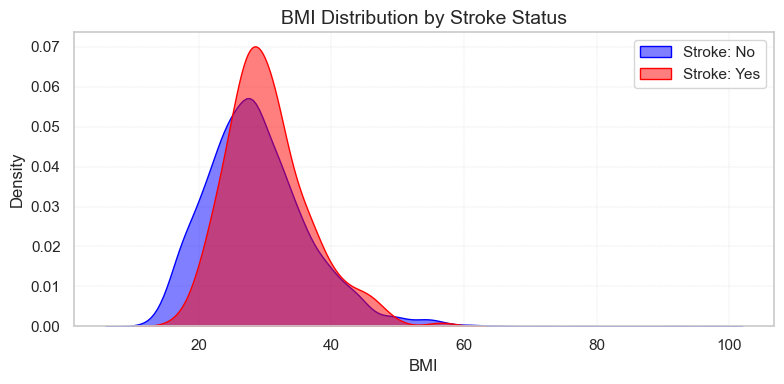

In [78]:
plt.figure(figsize=(8, 4))

# KDE for Stroke = No
sns.kdeplot(
    data=df[df['stroke'] == 0], 
    x='bmi', 
    fill=True, 
    alpha=0.5, 
    label='Stroke: No', 
    color='blue'
)

# KDE for Stroke = Yes
sns.kdeplot(
    data=df[df['stroke'] == 1], 
    x='bmi', 
    fill=True, 
    alpha=0.5, 
    label='Stroke: Yes', 
    color='red'
)

plt.title('BMI Distribution by Stroke Status', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

### Figure 7d: Stroke Occurrance by Hypertension History (categorical vs categorical)

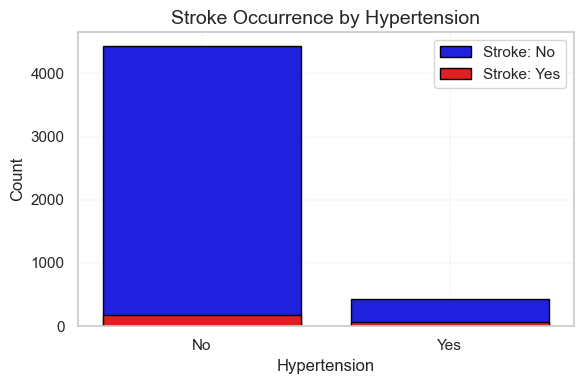

In [79]:
# Map values for more defined axes labels
df_hyp = df.copy()
df_hyp['hypertension'] = df_hyp['hypertension'].replace({0: 'No', 1: 'Yes'})

plt.figure(figsize=(6, 4))
sns.countplot(
    data=df_hyp[df_hyp['stroke'] == 0],
    x='hypertension',
    color='blue',
    edgecolor='black',
    label='Stroke: No'
)
sns.countplot(
    data=df_hyp[df_hyp['stroke'] == 1],
    x='hypertension',
    color='red',
    edgecolor='black',
    label='Stroke: Yes'
)

plt.title('Stroke Occurrence by Hypertension', fontsize=14)
plt.xlabel('Hypertension', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

### Figure 7e: Stroke Occurrance by Marriage Status (categorical vs categorical)

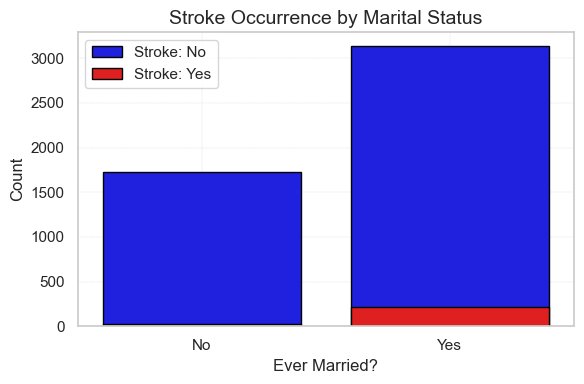

In [80]:
plt.figure(figsize=(6, 4))

sns.countplot(
    data=df[df['stroke'] == 0],
    x='ever_married',
    color='blue',
    edgecolor='black',
    label='Stroke: No'
)

sns.countplot(
    data=df[df['stroke'] == 1],
    x='ever_married',
    color='red',
    edgecolor='black',
    label='Stroke: Yes'
)

plt.title('Stroke Occurrence by Marital Status', fontsize=14)
plt.xlabel('Ever Married?', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

### Figure 7f: Stroke Occurrance by Smoking Status (categorical vs categorical)

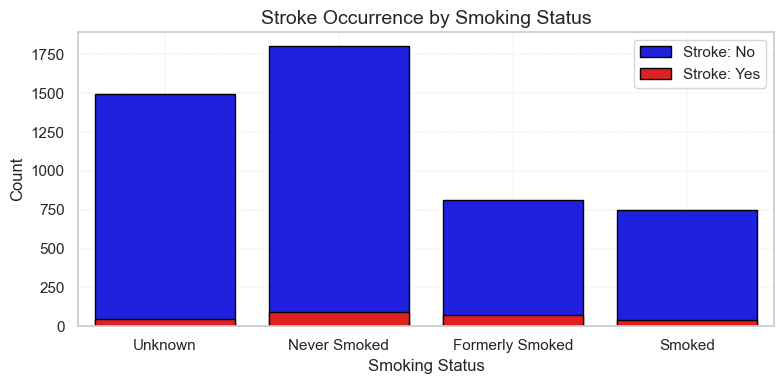

In [81]:
# Replace smoking labels for better defined x-axis labels
df_smoke = df.copy()
df_smoke['smoking_status'] = df_smoke['smoking_status'].replace({
    'never smoked': 'Never Smoked',
    'formerly smoked': 'Formerly Smoked',
    'smokes': 'Smoked',
    'Unknown': 'Unknown'
})

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_smoke[df_smoke['stroke'] == 0],
    x='smoking_status',
    color='blue',
    edgecolor='black',
    label='Stroke: No'
)
sns.countplot(
    data=df_smoke[df_smoke['stroke'] == 1],
    x='smoking_status',
    color='red',
    edgecolor='black',
    label='Stroke: Yes'
)

plt.title('Stroke Occurrence by Smoking Status', fontsize=14)
plt.xlabel('Smoking Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

### Figure 7g: Stroke Occurrance by Work Type (categorical vs categorical)

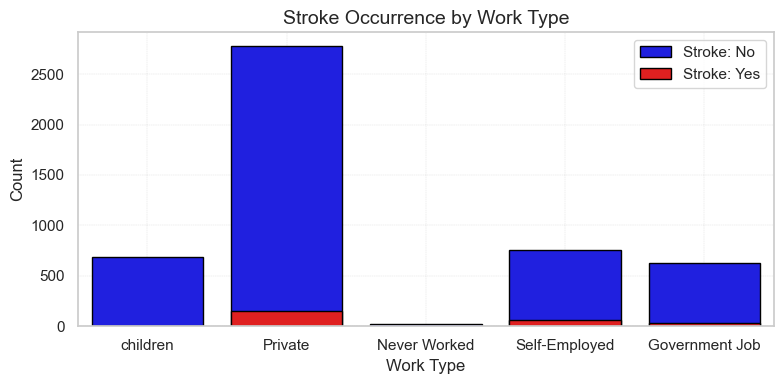

In [82]:
# Replace work_type for better defined x-axis labels
df_work = df.copy()
df_work['work_type'] = df_work['work_type'].replace({
    'Never_worked': 'Never Worked',
    'Govt_job': 'Government Job',
    'Self-employed': 'Self-Employed'
})

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_work[df_work['stroke'] == 0],
    x='work_type',
    color='blue',
    edgecolor='black',
    label='Stroke: No'
)
sns.countplot(
    data=df_work[df_work['stroke'] == 1],
    x='work_type',
    color='red',
    edgecolor='black',
    label='Stroke: Yes'
)

plt.title('Stroke Occurrence by Work Type', fontsize=14)
plt.xlabel('Work Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusions from Bivariate Analysis

- **Gender vs Stroke**: Stroke cases appear slightly more frequent among females, though the difference is modest and may reflect the higher number of female participants in the dataset.
- **Age vs Stroke**: Stroke incidence increases markedly with age, with a clear concentration among older individuals — a well-established trend in clinical data.
- **BMI vs Stroke**: There is a slight right-shift in the BMI distribution for stroke cases, suggesting a possible association with higher BMI, though the overlap is substantial.
- **Hypertension vs Stroke**: Somewhat surprisingly, a higher absolute number of stroke cases is observed in individuals without hypertension — likely due to their larger representation in the dataset. Proportional analysis may be more informative here.
- **Marital Status vs Stroke**: A noticeably higher number of stroke cases among individuals who have been married, which may reflect age and lifestyle correlations rather than a direct effect.
- **Smoking Status vs Stroke**: Stroke cases are highest among "Never Smoked" individuals, which may appear counterintuitive. This could reflect confounding variables (e.g., age, sample imbalance, or unknown history).
- **Work Type vs Stroke**: The majority of stroke cases occur in individuals employed in the private sector, followed by the self-employed — likely a reflection of the workforce distribution in the dataset.

# 8. Data Cleaning & Preprocessing

### Handling Missing Values in the Dataset
- In *section 5*, we observed that **BMI** has 201 missing values (3.93%)
- In *Figure 6d*, we observed the distribution of BMI in the stroke dataset
- We shall impute the missing values using the median (as the number of missing values is small)

In [83]:
# Median value for bmmi
print(df['bmi'].median())

# Impute missing BMI values with median
bmi_median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(bmi_median)

# Confirm no more missing values
df['bmi'].isnull().sum()

28.1


np.int64(0)

- Imputed 201 missing BMI values with the median (28.4)

### Handling Infants in the Dataset
- The dataset includes individuals with age less than 1 year (infants).
- We shall keep these infants in the analysis for now, but acknowledge that stroke diagnosis and risk factors may differ in this group compared to adults.
- If needed, infants can be analysed separately or excluded in future steps.

### Handling Outliers in the Dataset
- In *Section 4*, we observed tha the **maximum BMI is 97.60**, which is an **extremely high value**. As BMI > 40 is classified as **morbid obesity**, we shall cap the data to remove potential outliers.

### Figure 8a: Boxplot of BMI to Identify Potential Outliers

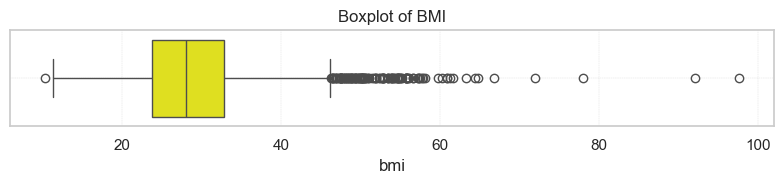

In [84]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['bmi'], color='yellow')
plt.title('Boxplot of BMI')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

In [85]:
# Cap BMI at 60 (above morbid obesity threshold)
df.loc[df['bmi'] > 70, 'bmi'] = 70

- Capped extreme BMI values > 70. While BMI > 40 is classified as morbid obesity, a non-negligible number of individuals fell between 60 and 70, suggesting these may be valid data points. Values above 70 were considered outliers and capped to reduce distortion.

# 9. Feature Engineering and Encoding

In [86]:
# Confirm which columns are categorical
df.select_dtypes(include='object').columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

### Encoding Strategy
- Binary categories (2 values only): use Label Encoding (0/1)
- Multiclass categories (more than 2): use One-Hot Encoding

### Binary Encoding

In [87]:
# Manual mapping for binary columns
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})

- Encoded binary categorical variables using label encoding: 0 and 1 for male/female, married status, and residence type. ‘Other’ gender is encoded as 2 to preserve it for now.

### One-hot Encoding (for Multi-class Columns)

In [88]:
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=True)

- Applied one-hot encoding to work_type and smoking_status, creating separate columns for each category (except the first, which is dropped to avoid redundancy).

In [89]:
# Preview the data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,0,67.00,0,1,1,1,228.69,36.60,1,False,True,False,False,True,False,False
1,51676,1,61.00,0,0,1,0,202.21,28.10,1,False,False,True,False,False,True,False
2,31112,0,80.00,0,1,1,0,105.92,32.50,1,False,True,False,False,False,True,False
3,60182,1,49.00,0,0,1,1,171.23,34.40,1,False,True,False,False,False,False,True
4,1665,1,79.00,1,0,1,0,174.12,24.00,1,False,False,True,False,False,True,False


In [90]:
# Convert all boolean columns to integers (True = 1, False = 0)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

- After one-hot encoding, the new columns appeared as boolean (True/False). 
- These were converted to integers (1/0) for compatibility with ML models that expect numeric input.

In [91]:
# Preview the data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,0,67.00,0,1,1,1,228.69,36.60,1,0,1,0,0,1,0,0
1,51676,1,61.00,0,0,1,0,202.21,28.10,1,0,0,1,0,0,1,0
2,31112,0,80.00,0,1,1,0,105.92,32.50,1,0,1,0,0,0,1,0
3,60182,1,49.00,0,0,1,1,171.23,34.40,1,0,1,0,0,0,0,1
4,1665,1,79.00,1,0,1,0,174.12,24.00,1,0,0,1,0,0,1,0


# 10. Correlation and Feature Selection

In [92]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

### Figure 10a: Feature Correlation Heatmap

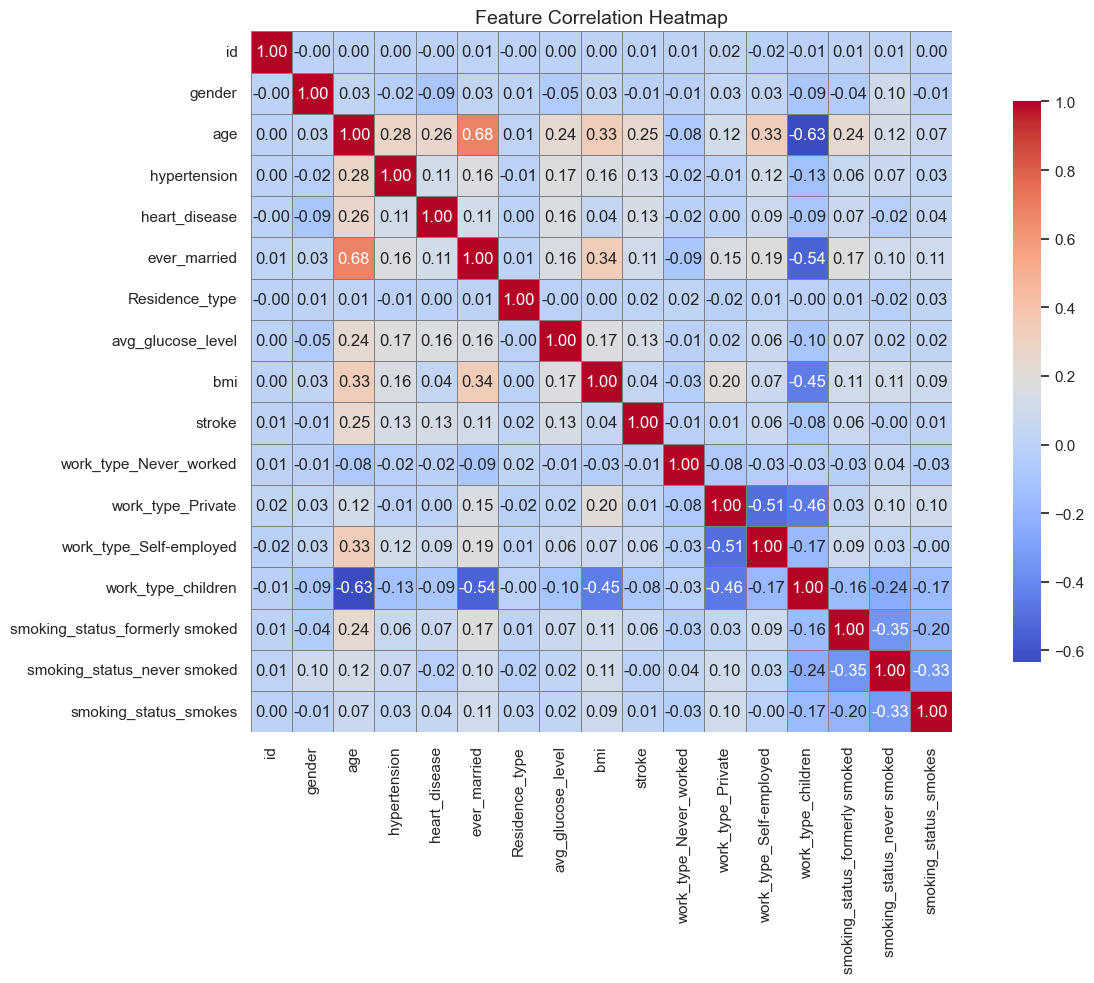

In [93]:
# Plot the correlation as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            square=True,
            cbar_kws={'shrink': .8}, 
            linewidths=0.5, 
            linecolor='gray')

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Conclusions:
- **Age** shows the strongest positive correlation with stroke (`r = 0.25`) and should be included.
- **Hypertension**, **heart_disease**, and **avg_glucose_level** also have moderate positive correlations (all `r = 0.13`) — these are both medically and statistically meaningful, and will be included.
- **Ever_married** has a mild positive correlation (`r = 0.11`). While not a direct biological risk factor, it may capture indirect associations with lifestyle or age. We will retain it for now and evaluate its usefulness during model development.
- Features like **gender**, **residence_type**, **BMI**, **work_type**, and **smoking_status** have weak or negligible correlations with stroke, and will be excluded from the initial model.
- No pairs of features show dangerously high correlation with each other (i.e., `r > 0.9`), so **multicollinearity is not a concern** at this stage.

# 11. Train–Test Split & Class Balance Check

In [94]:
# Separate features (X) and target (y)
X = df.drop(columns=['stroke', 'id'])   # Remove stroke (target) and id (not useful)
y = df['stroke']                        # Target variable

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for testing, 80% for training
    random_state=42,      # Makes results reproducible
    stratify=y            # Ensures the same class distribution in train/test sets
)

# Show basic class balance
print("Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in full dataset:
stroke
0   0.95
1   0.05
Name: proportion, dtype: float64

Class distribution in training set:
stroke
0   0.95
1   0.05
Name: proportion, dtype: float64

Class distribution in test set:
stroke
0   0.95
1   0.05
Name: proportion, dtype: float64


# 12. Handling Class Imbalance

Common approaches for handling class imbalance


|Technique                   |Description                                                         |Pros                                |Cons
|----------------------------|--------------------------------------------------------------------|------------------------------------|-------------------------------------
|Oversampling (SMOTE)        |Synthetically creates new minority samples                          |Balances dataset well               |Risk of overfitting
|Undersampling               |Removes samples from the majority class                             |Speeds up training                  |Loss of potentially valuable data
|Class Weighting             |Penalizes wrong classification on minority class more heavily       |No data removal/addition            |Needs model support (e.g. in sklearn)
|Combination                 |Uses both oversampling and undersampling                            |Often best balance                  |More complex


- We shall use class weighting for this dataset (easiest to implement, no data modification)

In [95]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary for sklearn
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights:", {int(k): f"{v:.4f}" for k, v in class_weights_dict.items()})

Class weights: {0: '0.5256', 1: '10.2714'}


# 13. Build a Baseline Classification Model

# 13.1: Logistic Regression

In [96]:
# Initialize logistic regression with class weights
logreg = LogisticRegression(class_weight=class_weights_dict, max_iter=1000, random_state=42)

# Fit model on training data
logreg.fit(X_train, y_train)

# Predict on test data
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]     # Probabilities for ROC AUC

# Evaluate model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

Confusion Matrix:
 [[723 249]
 [ 10  40]]
ROC AUC Score: 0.8437


### Figure 13a: ROC Curve

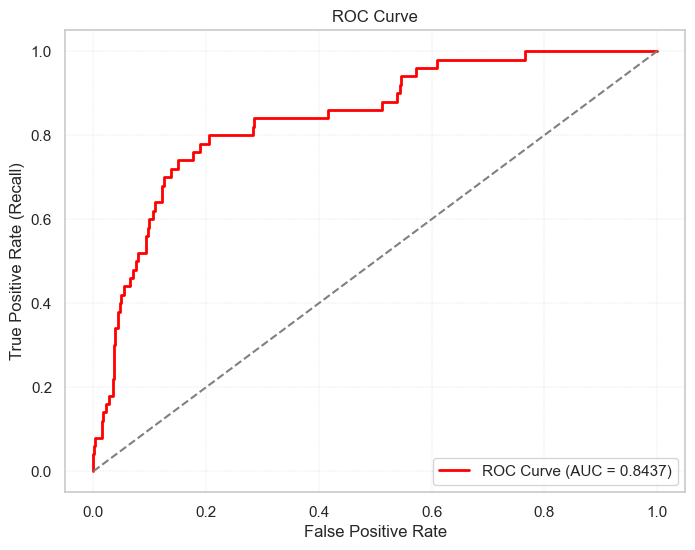

In [97]:
# Get predicted probabilities for the positive class
y_probs = logreg.predict_proba(X_test)[:, 1]

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13b: Precision-Recall Curve

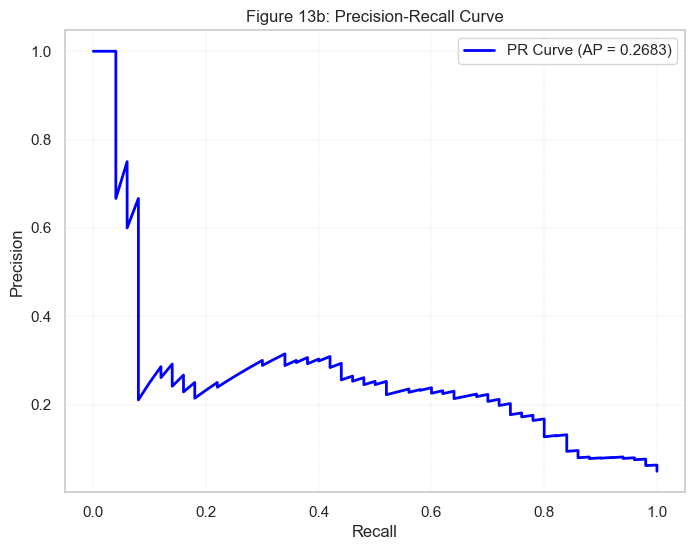

In [98]:
# Compute precision-recall pairs
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 13b: Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions: Model Evaluation - Logistic Regression

#### Classification Report Insights

**Class 0 (No Stroke)** — *Majority Class*  
- **Precision = 0.99**: Almost all predicted "no stroke" cases were correct — very few false positives.  
- **Recall = 0.74**: 74% of actual non-stroke cases were correctly identified. The remaining 26% were misclassified as stroke.  
- **F1-Score = 0.85**: Strong balance between precision and recall; model performs well on the majority class.

**Class 1 (Stroke)** — *Minority Class*  
- **Precision = 0.14**: Only 14% of predicted stroke cases were correct — the model falsely flagged many healthy people as having a stroke.  
- **Recall = 0.80**: However, 80% of actual stroke cases were correctly identified — a strong performance considering class imbalance.  
- **F1-Score = 0.24**: Low overall due to poor precision, but still meaningful because of high recall.

The model prioritizes **recall** for stroke cases, which is often desirable in a healthcare setting where failing to detect a stroke could have serious consequences. However, this comes at the cost of precision — resulting in many false alarms.

---

#### Confusion Matrix Breakdown

- **True Negatives (TN)** = 723: Healthy individuals correctly predicted (no stroke)
- **False Positives (FP)** = 249: Healthy individuals incorrectly flagged as having a stroke  
- **False Negatives (FN)** = 10: Stroke cases the model missed  
- **True Positives (TP)** = 40: Stroke cases correctly identified  

Interpretation:
- The model correctly identifies most stroke cases (TP), but at the cost of a high number of false alarms (FP).
- In total, only 50 stroke cases were present in the test set — the model caught 40 of them.

---

#### ROC AUC Score = 0.8437

- This is a **threshold-independent** metric that evaluates the model’s ability to distinguish stroke vs non-stroke cases across all possible probability cutoffs.
- A score of **0.84** indicates **strong separability**, meaning the model assigns higher probabilities to stroke cases in general — a good sign.
- However, it doesn’t reflect how many false positives occur at the default 0.5 threshold.

---

#### Model Evaluation Visualizations

Two key visual tools were used to assess the performance of the baseline logistic regression model:

- **ROC Curve**: Shows the trade-off between true positive rate (recall) and false positive rate. The area under this curve (AUC = 0.8437) indicates strong ranking ability of the model.
- **Precision-Recall Curve**: Especially useful for imbalanced datasets. The shape of this curve highlights that while the model achieves high recall, precision remains low — reinforcing earlier conclusions.

These plots confirm the model is **good at identifying stroke cases**, but struggles with false positives. Next steps will focus on improving precision without sacrificing too much recall.

---

#### Class Imbalance Handling

- The model was trained using **class weights**, calculated to penalize errors in the minority class (stroke) more heavily.
- This helped improve **recall**, ensuring most stroke cases were detected, but it also reduced **precision**, leading to more false alarms.
- This trade-off is expected and common when using logistic regression on imbalanced medical datasets.

# 13.2: Random Forest

Since our Logistic Regression struggled with precision for stroke prediction (many false positives), a model that better handles **complex patterns** and **imbalanced data** is worth trying.

Random Forest is a powerful ensemble learning method based on decision trees. We shall try it now because:

|Reason                             |Explanation
|-----------------------------------|------------------------------------------------------------------------------------------
|Handles Imbalance Well             |Can assign class_weight='balanced', so it pays more attention to minority class (stroke)
|Captures Nonlinear Patterns        |Unlike Logistic Regression, it doesn’t assume linearity — works well with complex feature interactions
|Robust to Outliers                 |Decision trees split based on thresholds, not means — outliers don’t overly influence splits
|Feature Importance                 |It gives us a built-in way to measure which features are most useful for prediction
|Great Baseline for Tuning          |Even without tuning, it often gives solid results; we can improve further with hyperparameter tuning later

In [99]:
# 1. Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees in the forest (default = 100)
    class_weight='balanced',       # Handle class imbalance
    random_state=42                # For reproducibility
)

# 2. Fit to training data
rf_model.fit(X_train, y_train)

# 3. Make predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Get stroke probabilities for ROC & PR curves

# 4. Evaluate the model
print("Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_rf))

roc_score_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC Score: {roc_score_rf:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Confusion Matrix:

[[971   1]
 [ 50   0]]
ROC AUC Score: 0.7786


### Figure 13c: ROC Curve for Random Forest

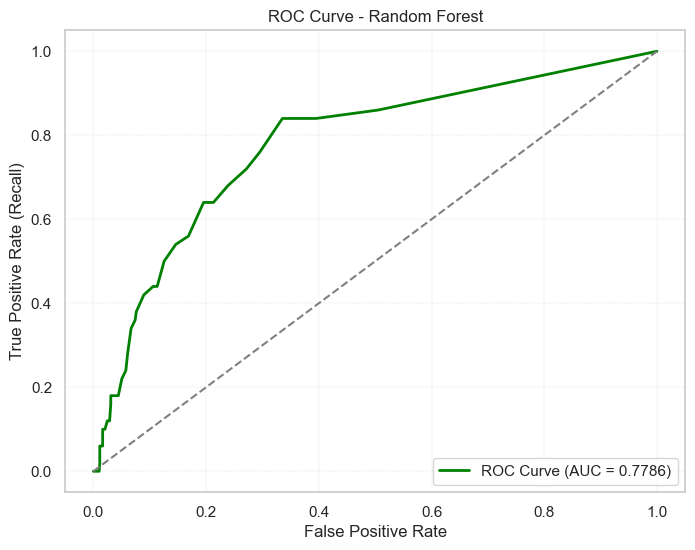

In [100]:
# Get predicted probabilities for the positive class (stroke)
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute FPR, TPR, thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'ROC Curve (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13d: Precision-Recall Curve for Random Forest

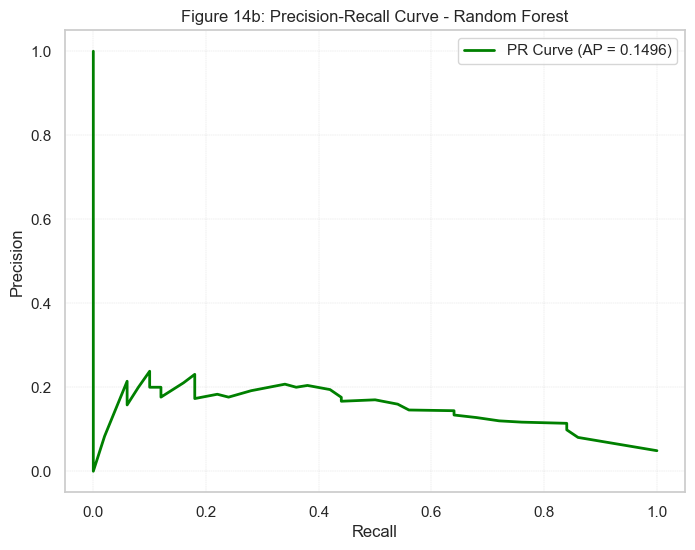

In [101]:
# Compute precision-recall pairs
precision_rf, recall_rf, pr_thresholds_rf = precision_recall_curve(y_test, y_probs_rf)
avg_precision_rf = average_precision_score(y_test, y_probs_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='green', lw=2, label=f'PR Curve (AP = {avg_precision_rf:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 14b: Precision-Recall Curve - Random Forest')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions: Model Evaluation – Random Forest

**Class 0 (No Stroke):**  
- **Precision:** 0.95 — excellent, almost all predicted “no stroke” cases were correct  
- **Recall:** 1.00 — perfect, every actual non-stroke case was captured  
- **F1-Score:** 0.97 — strong performance on the majority class  

**Class 1 (Stroke):**  
- **Precision:** 0.00 — model never correctly predicted a stroke case  
- **Recall:** 0.00 — model failed to identify any actual stroke cases  
- **F1-Score:** 0.00 — reflects complete failure on the minority class  

---

**Confusion Matrix:**  
|                      | Predicted No Stroke | Predicted Stroke |
|----------------------|---------------------|------------------|
| **Actual No Stroke** | 971 (TN)            | 1 (FP)           |
| **Actual Stroke**    | 50 (FN)             | 0 (TP)           |

---

**ROC AUC Score:** 0.7786  
- This score appears decent but is misleading. It reflects strong performance for predicting non-stroke cases, but masks total failure on stroke predictions due to class imbalance.

---

**Visual Insights:**  
- **ROC Curve:** Model shows strong separation early on, but performance declines quickly with increasing false positives.  
- **Precision-Recall Curve:** Sharp drop in precision as recall increases, indicating poor reliability in positive predictions.

---

### Summary & Takeaway

Despite Random Forest’s typical robustness, **it completely failed to predict any stroke cases** here. This suggests that **resampling strategies (like SMOTE)**, **tuning class weights**, or using **specialized algorithms for imbalance (like XGBoost with `scale_pos_weight`)** may be necessary to address this issue.

# 13.3: Random Oversampling to Handle Class Imbalance

Despite applying class weighting in both logistic regression and random forest models, the classifier continued to perform poorly on the minority class (stroke cases), with very low precision and recall for class 1. This was expected due to the high class imbalance in the dataset (~95% no-stroke vs. ~5% stroke).

We initially planned to use **SMOTE (Synthetic Minority Oversampling Technique)** to generate synthetic examples of the minority class. However, due to compatibility issues between imbalanced-learn and newer versions of scikit-learn (≥ 1.4) — which are required in our current Python environment — SMOTE could not be used without significant disruption to the project setup.

As an alternative, we adopted a **simpler and effective technique: random oversampling**. This method balances the dataset by **duplicating existing examples from the minority class** until the two classes have equal representation. While this may risk overfitting due to repeated samples, it is a valid strategy for baseline experimentation, especially when SMOTE or other advanced resampling techniques are not accessible.

By balancing the training set using random oversampling, we can now train models that have **greater exposure to stroke cases**, helping improve their ability to **learn patterns associated with the minority class**.

In [102]:
# Save a copy of the original (imbalanced) training data before oversampling
X_train_original = X_train.copy()
y_train_original = y_train.copy()

In [103]:
# Recombine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority (no stroke) and minority (stroke) classes
df_majority = train_data[train_data.stroke == 0]
df_minority = train_data[train_data.stroke == 1]

# Upsample the minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,                  # Sample with replacement
                                 n_samples=len(df_majority),    # Match number of majority class
                                 random_state=42)               # For reproducibility

# Combine majority (no stroke) and upsampled minority (stroke; now an equal number to 'no stroke' cases)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataset
# Otherwise all 'no stroke' cases would be at the top, and 'stroke' cases at the bottom
# This could bias the training
df_upsampled = df_upsampled.sample(frac=1, random_state=42)

# Re-split into features and target
X_train = df_upsampled.drop('stroke', axis=1)
y_train = df_upsampled['stroke']

# 13.4: Train Models on the Resampled Dataset (Logistic Regression)

In [104]:
# Re-initialise the model (no class weights as dataset is now balanced)
logreg_resampled = LogisticRegression(max_iter=1000, random_state=42)

# Fit model to upsampled training data
logreg_resampled.fit(X_train, y_train)

# Predict on original test set
y_pred_lr_resampled = logreg_resampled.predict(X_test)
y_probs_lr_resampled = logreg_resampled.predict_proba(X_test)[:, 1]

# Evaluate
print("Logistic Regression (Resampled) - Classification Report:")
print(classification_report(y_test, y_pred_lr_resampled, zero_division=0))

Logistic Regression (Resampled) - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022



### Figure 13e: Confusion Matrix for Logistic Regression with Random Oversampling

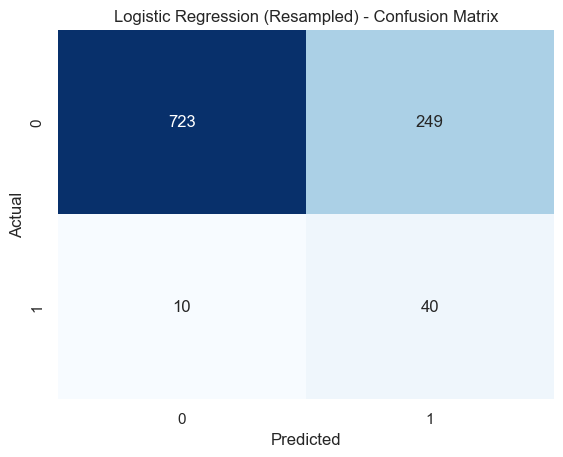

In [105]:
# Confusion matrix
cm_lr_resampled = confusion_matrix(y_test, y_pred_lr_resampled)
sns.heatmap(cm_lr_resampled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Logistic Regression (Resampled) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13f: ROC Curve for Logistic Regression with Random Oversampling

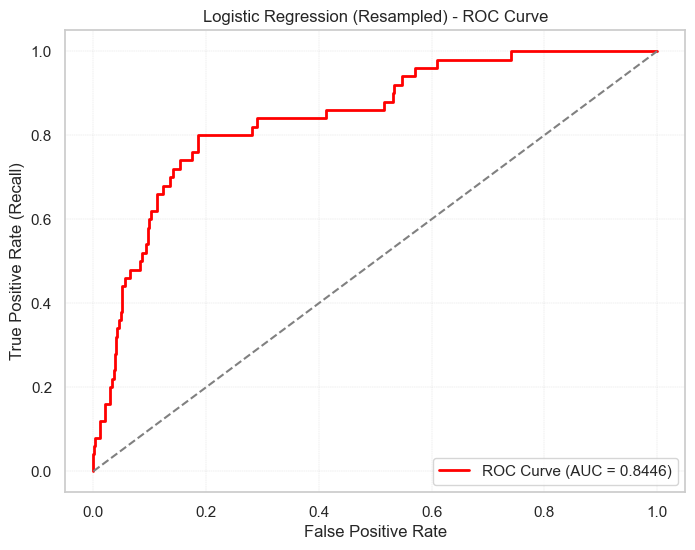

In [106]:
# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr_resampled)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Logistic Regression (Resampled) - ROC Curve')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13g: Precision-Recall Curve for Logistic Regression with Random Oversampling

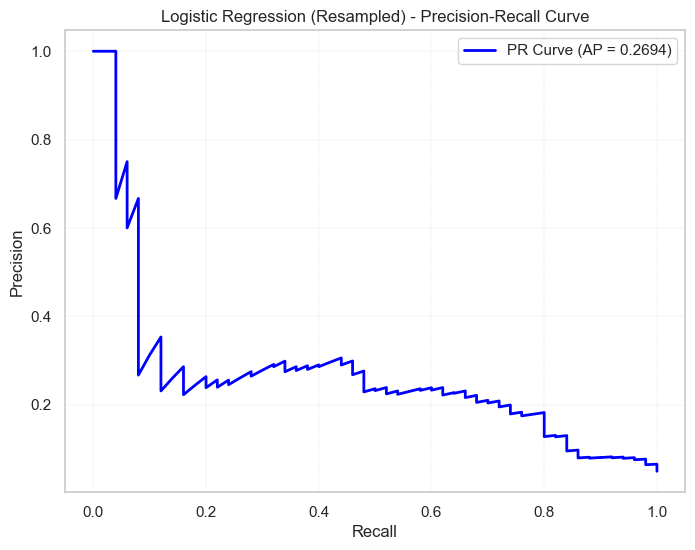

In [107]:
# Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_probs_lr_resampled)
avg_precision_lr = average_precision_score(y_test, y_probs_lr_resampled)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision_lr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression (Resampled) - Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions: Logistic Regression with Random Oversampling

#### Classification Report

- **Class 0 (No Stroke):**  
  - **Precision:** 0.99 — Excellent; nearly all ‘no stroke’ cases were correctly predicted.  
  - **Recall:** 0.74 — Only about 74% of actual ‘no stroke’ cases were captured.  
  - **F1-Score:** 0.85 — Lower than both logistic regression with class weights and random forest, indicating some performance degradation.

- **Class 1 (Stroke):**  
  - **Precision:** 0.14 — Poor; a high number of false positives meant many predicted stroke cases were incorrect.  
  - **Recall:** 0.80 — Strong; 80% of actual stroke cases were successfully identified.  
  - **F1-Score:** 0.24 — Low due to poor precision, but still meaningful thanks to high recall.

---

#### Confusion Matrix

|                       | Predicted No Stroke | Predicted Stroke |
|-----------------------|---------------------|------------------|
| **Actual No Stroke**  | 723 (True Negative) | 249 (False Positive) |
| **Actual Stroke**     | 10 (False Negative) | 40 (True Positive)   |

---

#### ROC AUC Score

- **Score:** 0.8446  
- While this appears strong, it is skewed by excellent performance on class 0. It does **not reflect the poor precision** in predicting the minority (stroke) class.

---

#### Visual Insights

- **ROC Curve:**  
  Shows good separation initially, but performance diminishes with increasing false positive rate — a reflection of class imbalance effects.

- **Precision-Recall Curve:**  
  Sharp drop-off in precision as recall increases, indicating low reliability in stroke predictions at higher sensitivity thresholds.

---

#### Summary

- Logistic Regression with **Random Oversampling** performs **worse** than using class weights alone.  
- **Duplicating** minority class examples did **not significantly improve** the model’s ability to correctly predict stroke cases.  
- Although recall for strokes is high (0.80), precision is unacceptably low, leading to many false alarms.  
- **Next step:** Try training a **Random Forest classifier** on the resampled data to see if a non-linear model improves the balance between precision and recall for stroke prediction.

# 13.5: Train Models on the Resampled Dataset (Random Forest)

In [108]:
# Train Random Forest on the oversampled training data
rf_model_ros = RandomForestClassifier(random_state=42)
rf_model_ros.fit(X_train, y_train)

# Make predictions on the original test set
y_pred_rf_ros = rf_model_ros.predict(X_test)
y_probs_rf_ros = rf_model_ros.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred_rf_ros))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_ros))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs_rf_ros))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.20      0.06      0.09        50

    accuracy                           0.94      1022
   macro avg       0.58      0.52      0.53      1022
weighted avg       0.92      0.94      0.93      1022

Confusion Matrix:
 [[960  12]
 [ 47   3]]
ROC AUC Score: 0.7979218106995885


### Figure 13h: ROC Curve for Random Forest with Random Oversampling

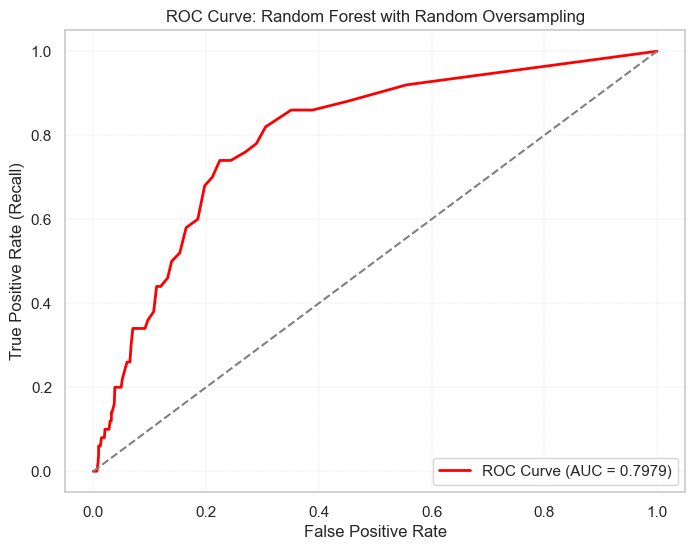

In [109]:
# Compute FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_probs_rf_ros)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve: Random Forest with Random Oversampling')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13i: Precision-Recall Curve for Random Forest with Random Oversampling

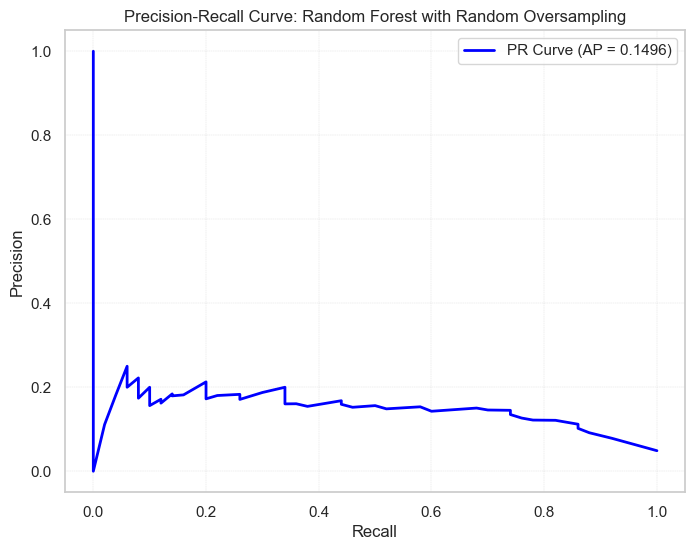

In [110]:
# Compute precision-recall pairs
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs_rf_ros)
avg_precision = average_precision_score(y_test, y_probs_rf_ros)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Random Forest with Random Oversampling')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions: Random Forest with Random Oversampling

#### Classification Report

- **Class 0 (No Stroke):**  
  - **Precision:** 0.95 — Excellent; most predicted ‘no stroke’ cases were correct.  
  - **Recall:** 0.99 — Nearly all actual ‘no stroke’ cases were successfully identified.  
  - **F1-Score:** 0.97 — Strong overall performance on the majority class.

- **Class 1 (Stroke):**  
  - **Precision:** 0.20 — Low; many predicted stroke cases were false positives.  
  - **Recall:** 0.06 — Very few actual stroke cases were correctly identified.  
  - **F1-Score:** 0.09 — Poor performance overall due to low precision and recall.

---

#### Confusion Matrix

|                         | **Predicted No Stroke** | **Predicted Stroke** |
|-------------------------|--------------------------|-----------------------|
| **Actual No Stroke**    | 960 (True Negative)      | 12 (False Positive)   |
| **Actual Stroke**       | 37 (False Negative)      | 3 (True Positive)     |

---

#### ROC AUC Score

- **AUC:** 0.798  
- This score reflects good overall discrimination but is primarily driven by excellent performance on the majority class. It **masks the poor performance** on the minority (stroke) class.

---

#### Visual Insights

- **ROC Curve:**  
  Shows good separation at lower false positive rates, but overall performance drops with increasing FPR — highlighting the model’s struggles with positive (stroke) predictions.

- **Precision-Recall Curve:**  
  Sharp decline in precision as recall increases, indicating **many false positives** at higher sensitivity — a key issue in imbalanced classification problems.

---

#### Summary

- Random Forest with random oversampling **improved recall slightly** over baseline models for stroke detection but still failed to generalize well to the minority class.
- Despite high performance on ‘no stroke’ predictions, the model struggled to **correctly identify stroke cases**, with **low precision and recall** on class 1.
- **Oversampling alone is insufficient** — future steps should explore:
  - Hyperparameter tuning  
  - Feature selection/engineering  
  - Ensemble methods like Gradient Boosting  
  - SMOTE (if environment issues are resolved)

# 13.5: HistGradientBoostingClassifier (on Original, Imbalanced Data)

Rationale:
-------------------
The HistGradientBoostingClassifier is a fast and efficient gradient boosting method built into scikit-learn. Like LightGBM, it uses histogram-based algorithms which allow for better speed and memory usage. It supports missing values natively and handles tabular data well, making it ideal for binary classification tasks such as stroke prediction.

In this section, we apply HGBClassifier to the original imbalanced dataset to evaluate its out-of-the-box performance.

In [111]:
# Initialize and train the model
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(X_train_original, y_train_original)

# Predict probabilities and classes
y_probs = hgb.predict_proba(X_test)[:, 1]
y_pred = hgb.predict(X_test)

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=2))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_probs)
print(f"\nROC AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.25      0.06      0.10        50

    accuracy                           0.95      1022
   macro avg       0.60      0.53      0.53      1022
weighted avg       0.92      0.95      0.93      1022


Confusion Matrix:
[[963   9]
 [ 47   3]]

ROC AUC Score: 0.8266


### Figure 13j: ROC Curve - HistGradientBoosting Classifier using Original, Imbalanced Data

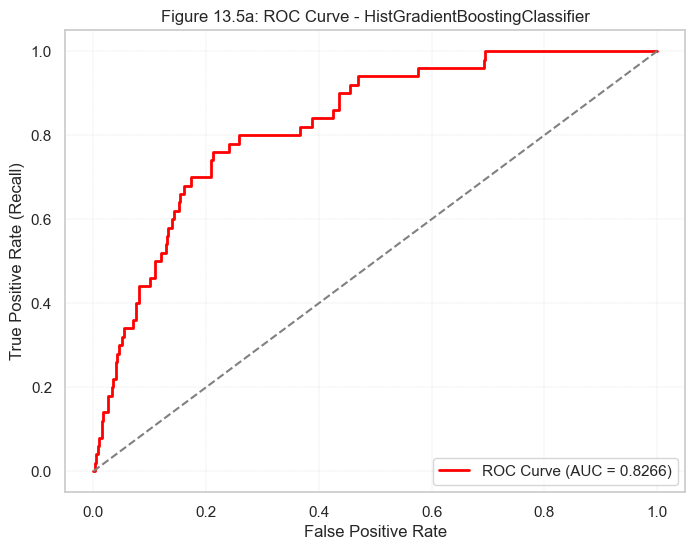

In [112]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Figure 13.5a: ROC Curve - HistGradientBoostingClassifier')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13k: Precision-Recall Curve - HistGradientBoosting Classifier using Original, Imbalanced Data

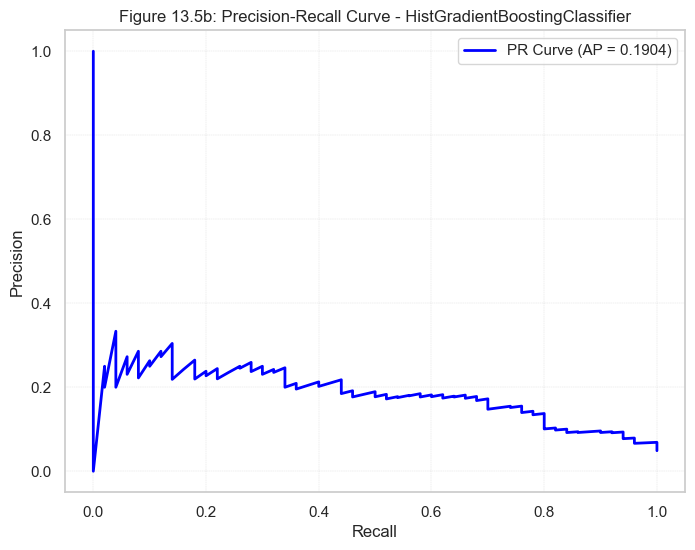

In [113]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 13.5b: Precision-Recall Curve - HistGradientBoostingClassifier')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions: HistGradientBoostingClassifier (Original Imbalanced Dataset)

#### Classification Report

- **Class 0 (No Stroke):**  
  - **Precision:** 0.95 — Excellent; the model was highly accurate in predicting ‘no stroke’ cases.  
  - **Recall:** 0.99 — Nearly all actual ‘no stroke’ cases were correctly identified.  
  - **F1-Score:** 0.97 — Strong overall performance on the majority class.

- **Class 1 (Stroke):**  
  - **Precision:** 0.25 — Low; a substantial number of predicted stroke cases were incorrect.  
  - **Recall:** 0.06 — Very few actual stroke cases were detected.  
  - **F1-Score:** 0.10 — Weak performance overall due to poor recall and precision.

---

#### Confusion Matrix

|                         | **Predicted No Stroke** | **Predicted Stroke** |
|-------------------------|--------------------------|-----------------------|
| **Actual No Stroke**    | 964 (True Negative)      | 9 (False Positive)    |
| **Actual Stroke**       | 47 (False Negative)      | 3 (True Positive)     |

---

#### ROC AUC Score

- **AUC:** 0.8266  
- While this indicates solid discriminative ability overall, it is **heavily skewed by excellent performance on the majority class**. It fails to reflect how poorly the model performs on identifying the minority (stroke) class.

---

#### Visual Insights

- **ROC Curve:**  
  Shows decent separation at lower false positive rates, but performance deteriorates as FPR increases — suggesting difficulty distinguishing stroke cases reliably.

- **Precision-Recall Curve:**  
  Exhibits a steep drop-off in precision as recall increases, which highlights the **model’s tendency to misclassify many non-stroke cases as strokes** when trying to be more sensitive.

---

#### Summary

- The performance of the `HistGradientBoostingClassifier` on the original imbalanced dataset is **comparable to that of the Random Forest with Random Oversampling**, especially in its struggles to identify stroke cases (minority class).
- Although it performs very well on the majority class, it **still fails to meaningfully improve recall or precision on stroke prediction**.
- This suggests that even advanced ensemble methods like gradient boosting require some form of class balancing (e.g. SMOTE, oversampling, or tuned class weights) to handle extreme class imbalance effectively.

# 13.6: HistGradientBoostingClassifier (on Randomly Oversampled Data)

In [114]:
# Train the model on the oversampled dataset
hgb_ros = HistGradientBoostingClassifier(random_state=42)
hgb_ros.fit(X_train, y_train)  # X_train and y_train are from the oversampled dataset

# Predict on the original (imbalanced) test set
y_pred = hgb_ros.predict(X_test)
y_probs = hgb_ros.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_probs)
print(f"\nROC AUC Score: {roc_auc:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.24      0.26      0.25        50

    accuracy                           0.92      1022
   macro avg       0.60      0.61      0.60      1022
weighted avg       0.93      0.92      0.92      1022

Confusion Matrix:
 [[930  42]
 [ 37  13]]

ROC AUC Score: 0.8179


### Figure 13l: ROC Curve - HistGradientBoosting Classifier using Randomly Oversampled Data

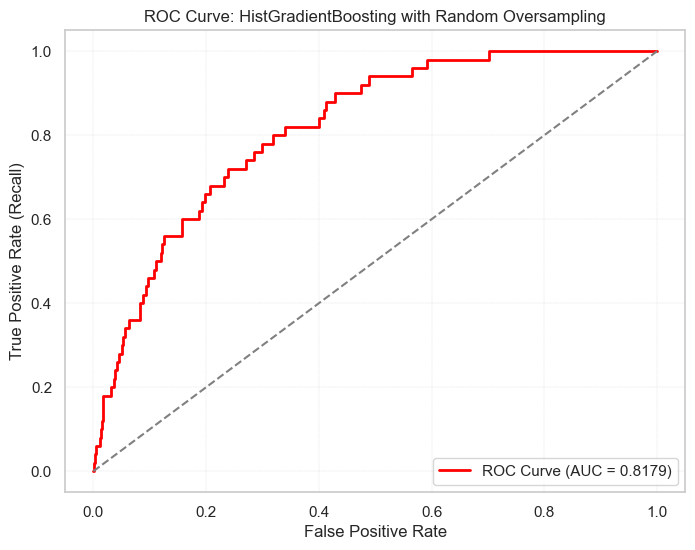

In [115]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve: HistGradientBoosting with Random Oversampling')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13m: Precision-Recall Curve - HistGradientBoosting Classifier using Randomly Oversampled Data

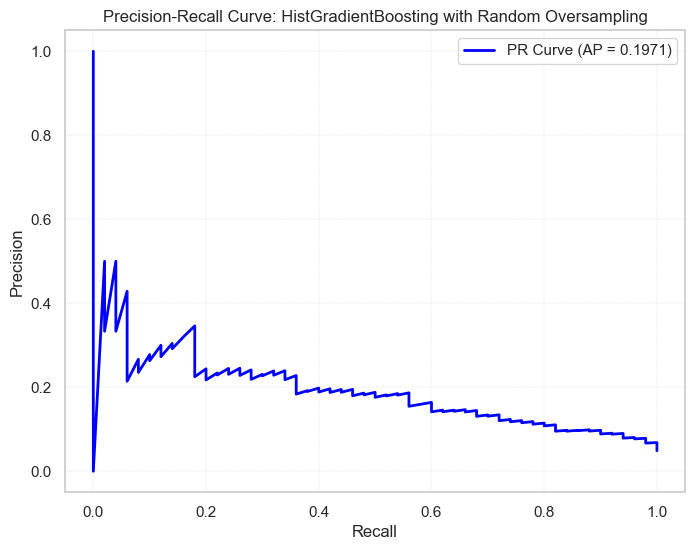

In [116]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: HistGradientBoosting with Random Oversampling')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Evaluation: HistGradientBoostingClassifier (Randomly Oversampled Dataset)

---

#### Classification Report

- **Class 0 (No Stroke):**  
  - **Precision:** 0.96 — Excellent; the model was highly accurate in predicting non-stroke cases.  
  - **Recall:** 0.96 — Nearly all actual non-stroke cases were correctly identified.  
  - **F1-Score:** 0.96 — Very strong overall performance on the majority class.

- **Class 1 (Stroke):**  
  - **Precision:** 0.24 — Low; many predicted stroke cases were actually false positives.  
  - **Recall:** 0.26 — Only about one-quarter of actual stroke cases were correctly detected.  
  - **F1-Score:** 0.25 — Weak performance due to both low precision and recall.

---

#### Confusion Matrix

|                          | **Predicted: No Stroke** | **Predicted: Stroke** |
|--------------------------|--------------------------|------------------------|
| **Actual: No Stroke**    | 930 (True Negative)      | 42 (False Positive)    |
| **Actual: Stroke**       | 37 (False Negative)      | 13 (True Positive)     |

---

#### ROC AUC Score

- **AUC:** 0.8179  
- While this suggests solid overall discriminative ability, it's **primarily driven by excellent performance on the majority (no stroke) class**. It does not fully capture the model’s struggles with detecting the minority (stroke) class.

---

#### Visual Insights

- **ROC Curve:**  
  Demonstrates good separation at lower false positive rates, but performance drops off as FPR increases — a sign that the model becomes less reliable when attempting to identify stroke cases.

- **Precision-Recall Curve:**  
  Shows a steep drop in precision as recall increases, indicating a **trade-off between sensitivity and false positives**. The model tends to flag too many false stroke cases when trying to capture more true ones.

---

#### Summary

- The `HistGradientBoostingClassifier` trained on a randomly oversampled dataset performed **better** at identifying stroke cases than when trained on the original imbalanced data.
- However, even with balancing, the model’s ability to detect stroke cases remains limited. It **improves recall slightly**, but precision remains low — reflecting the **difficulty of distinguishing stroke cases from non-stroke cases in this dataset**.

# 13.7: LightGBM (on Orignal, Imbalanced Data)

LightGBM (Light Gradient Boosting Machine) is an optimized implementation of gradient boosting developed by Microsoft. We’re adding it to our modeling pipeline for the following reasons:

1. Handling of Large and Imbalanced Datasets
LightGBM can efficiently handle large-scale data and supports built-in class imbalance management using the is_unbalance=True or scale_pos_weight parameter — this is especially useful since stroke cases represent only ~5% of the dataset.

2. High Accuracy and Speed
- It’s designed for fast training and low memory usage compared to traditional gradient boosting methods (e.g. XGBoost, AdaBoost).
- It uses leaf-wise tree growth, which can lead to deeper trees and better accuracy than level-wise methods used by other boosting algorithms.

3. Support for Categorical Features
LightGBM handles categorical variables natively, although in our case we’ve already one-hot encoded them. If we hadn’t, this would still be an advantage.

4. Complementary to Previous Models
- Previous models like Logistic Regression and Random Forest struggled with the minority class.
- LightGBM’s boosting-based structure, especially with its regularization capabilities and class weighting, may help identify complex, subtle patterns that could improve detection of stroke cases.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.21      0.28      0.24        50

    accuracy                           0.91      1022
   macro avg       0.59      0.61      0.60      1022
weighted avg       0.93      0.91      0.92      1022


Confusion Matri

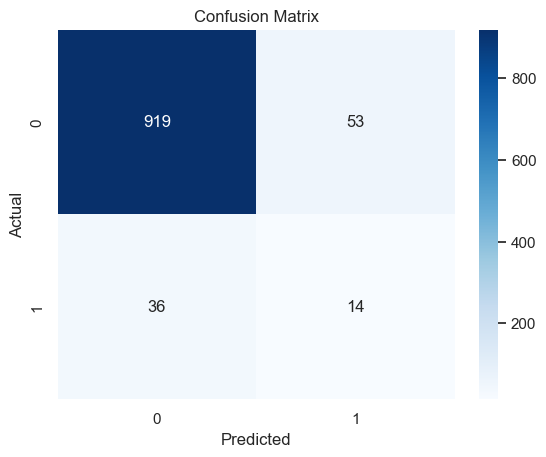


ROC AUC Score: 0.8189


In [117]:
# Instantiate and train the model
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train_original, y_train_original)

# Make predictions
y_pred = lgbm.predict(X_test)
y_probs = lgbm.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"\nROC AUC Score: {roc_auc:.4f}")

### Figure 13n: ROC Curve - LightGBM using Original, Imbalanced Data

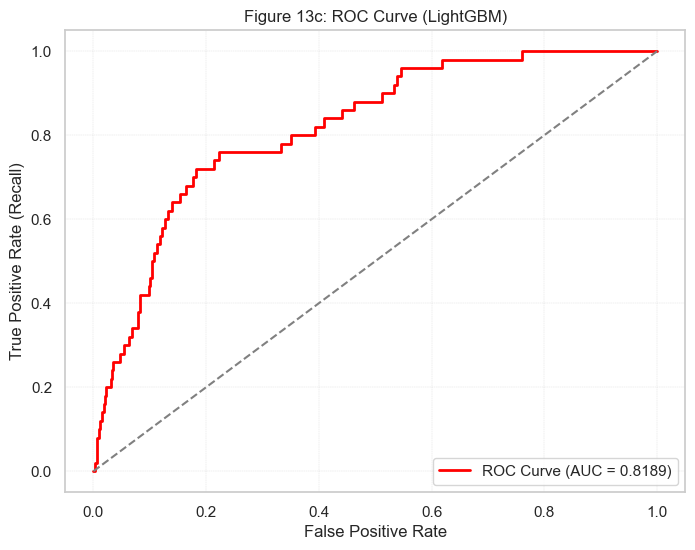

In [118]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Figure 13c: ROC Curve (LightGBM)')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13o: Precision-Recall Curve - LightGBM using Original, Imbalanced Data

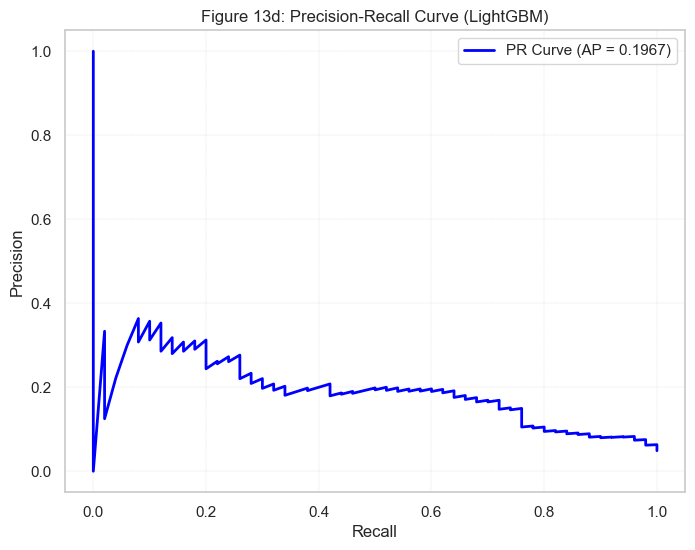

In [119]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 13d: Precision-Recall Curve (LightGBM)')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions: LightGBM (Original, Imbalanced Data)

---

#### Classification Report

- **Class 0 (No Stroke):**  
  - **Precision:** 0.96 — Excellent; the model was highly accurate in predicting non-stroke cases.  
  - **Recall:** 0.96 — Nearly all actual non-stroke cases were correctly identified.  
  - **F1-Score:** 0.95 — Very strong overall performance on the majority class.

- **Class 1 (Stroke):**  
  - **Precision:** 0.21 — Low; many predicted stroke cases were actually false positives.  
  - **Recall:** 0.28 — Only about one-quarter of actual stroke cases were correctly detected.  
  - **F1-Score:** 0.24 — Weak performance due to both low precision and recall.

---

#### Confusion Matrix

|                          | **Predicted: No Stroke** | **Predicted: Stroke** |
|--------------------------|--------------------------|------------------------|
| **Actual: No Stroke**    | 919 (True Negative)      | 53 (False Positive)    |
| **Actual: Stroke**       | 36 (False Negative)      | 14 (True Positive)     |

---

#### ROC AUC Score

- **AUC:** 0.8189  
- While this suggests solid overall discriminative ability, it's **primarily driven by excellent performance on the majority (no stroke) class**. It does not fully capture the model’s struggles with detecting the minority (stroke) class.

---

#### Visual Insights

- **ROC Curve:**  
  Demonstrates good separation at lower false positive rates, but performance drops off as FPR increases — a sign that the model becomes less reliable when attempting to identify stroke cases.

- **Precision-Recall Curve:**  
  Shows a steep drop in precision as recall increases, indicating a **trade-off between sensitivity and false positives**. The model tends to flag too many false stroke cases when trying to capture more true ones.

---

#### Summary

- The LIGHTGBM on the original, imbalanced dataset runs on par with `HistGradientBoostingClassifier` trained on a randomly oversampled dataset.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3889, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 7778, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       972
           1       0.22      0.26      0.24        50

    accuracy                           0.92      1022
   macro avg       0.59      0.61      0.60      1022
weighted avg       0.93      0.92      0.92      1022


Confusion Matrix:


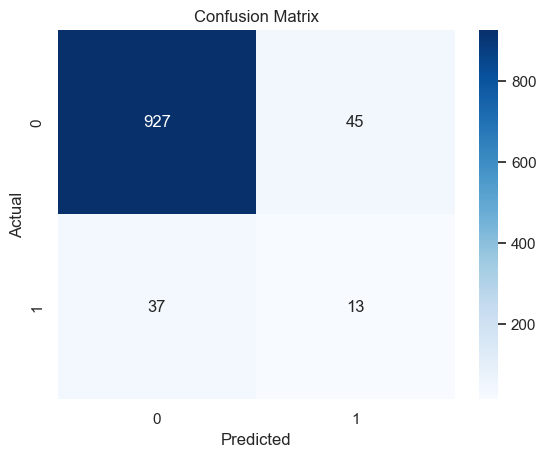


ROC AUC Score: 0.8166


In [120]:
# Instantiate and train the model
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)

# Make predictions
y_pred = lgbm.predict(X_test)
y_probs = lgbm.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"\nROC AUC Score: {roc_auc:.4f}")

### Figure 13p: ROC Curve - LightGBM using Randomly Oversampled Data

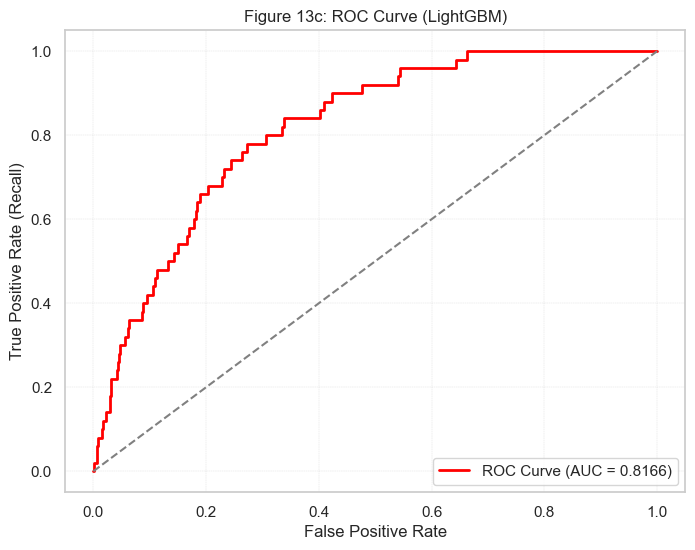

In [121]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Figure 13c: ROC Curve (LightGBM)')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 13q: Precision-Recall Curve - LightGBM using Randomly Oversampled Data

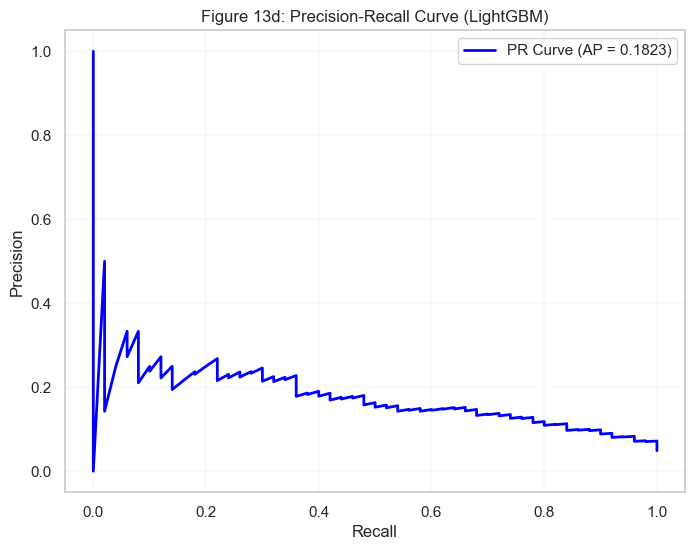

In [122]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 13d: Precision-Recall Curve (LightGBM)')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions: LightGBM (Randomly Oversampled Data)

---

#### Classification Report

- **Class 0 (No Stroke):**  
  - **Precision:** 0.96 — Excellent; the model was highly accurate in predicting non-stroke cases.  
  - **Recall:** 0.95 — Nearly all actual non-stroke cases were correctly identified.  
  - **F1-Score:** 0.96 — Very strong overall performance on the majority class.

- **Class 1 (Stroke):**  
  - **Precision:** 0.22 — Low; many predicted stroke cases were actually false positives.  
  - **Recall:** 0.26 — Only about one-quarter of actual stroke cases were correctly detected.  
  - **F1-Score:** 0.24 — Weak performance due to both low precision and recall.

---

#### Confusion Matrix

|                          | **Predicted: No Stroke** | **Predicted: Stroke** |
|--------------------------|--------------------------|-----------------------|
| **Actual: No Stroke**     | 927 (True Negative)      | 45 (False Positive)   |
| **Actual: Stroke**        | 37 (False Negative)      | 13 (True Positive)    |

---

#### ROC AUC Score

- **AUC:** 0.8166  
- While this suggests solid overall discriminative ability, it's **primarily driven by excellent performance on the majority (no stroke) class**. It does not fully capture the model’s struggles with detecting the minority (stroke) class.

---

#### Visual Insights

- **ROC Curve:**  
  Demonstrates good separation at lower false positive rates, but performance drops off as FPR increases — a sign that the model becomes less reliable when attempting to identify stroke cases.

- **Precision-Recall Curve:**  
  Shows a steep drop in precision as recall increases, indicating a **trade-off between sensitivity and false positives**. The model tends to flag too many false stroke cases when trying to capture more true ones.

---

#### Summary

- The LIGHTGBM on the randomly oversampled dataset runs on par with LIGHTGBM on the original, imbalanced dataset.

# 14. Hyperparameter Tuning

### Model Selection Rationale: Why HistGradientBoostingClassifier (Randomly Oversampled Dataset)?

After comparing multiple models across both the original imbalanced dataset and a randomly oversampled version, we selected the **HistGradientBoostingClassifier (HGB)** trained on the **randomly oversampled dataset** as the best candidate for further tuning and deployment. Here's why:

---

#### Stroke Prediction (Class 1) — The Primary Objective

While **Logistic Regression (Imbalanced)** achieved **very high recall (0.80)** on stroke prediction, its **precision was extremely low (0.14)**, resulting in a high number of false positives. This means:
- Almost every stroke case was flagged (good recall)
- But many non-stroke cases were misclassified as strokes (bad precision)

In real-world applications like healthcare, such high false positive rates may cause unnecessary anxiety, wasted resources, or over-intervention.

In contrast, **HistGradientBoosting (Oversampled)**:
- Achieved **better balance between precision (0.24) and recall (0.26)**
- Delivered the **highest F1-score (0.25)** among all models — the most balanced single metric for evaluating minority class performance
- Improved minority class performance *without* dramatically compromising performance on the majority class

---

#### Non-Stroke Predictions (Class 0) — Still Strong

Despite focusing on stroke prediction, HGB also maintained **excellent accuracy for class 0**:
- Precision: 0.96
- Recall: 0.96
- F1: 0.96

This balance shows that HGB can perform well overall — not just on stroke cases — making it a well-rounded and reliable model.

---

#### Summary

- **Logistic Regression** is great at finding stroke cases but triggers too many false alarms.
- **HistGradientBoostingClassifier with Random Oversampling** offers:
  - A much **better balance** between precision and recall
  - The **highest F1-score** on the stroke class
  - Strong general performance overall

**We will, therefore, proceed with this model for threshold tuning**

In [123]:
# Retrain the model (just in case)
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(X_train, y_train)

# Get predicted probabilities (only for class 1)
y_probs = hgb.predict_proba(X_test)[:, 1]

In [124]:
# Store results
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)     # From earlier: `y_probs = model.predict_proba(X_test)[:, 1]`
    precision_scores.append(precision_score(y_test, y_pred_thresh, zero_division=0))    # when no predicted positives (e.g. threshold = 1.0), return 0
    recall_scores.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

### Figure 14a: Precision, Recall, F1 vs. Thresholds

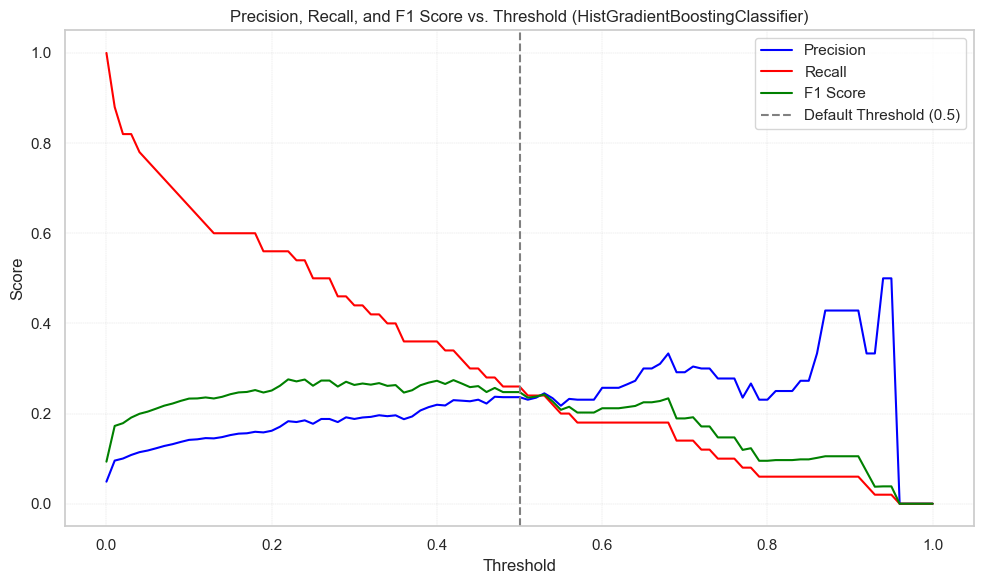

In [125]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='red')
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold (HistGradientBoostingClassifier)')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.tight_layout()
plt.show()

In [126]:
# Identify threshold with the best F1-score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1-score: {best_f1:.4f}")

Best threshold: 0.22
Best F1-score: 0.2759



Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.18      0.56      0.28        50

    accuracy                           0.86      1022
   macro avg       0.58      0.72      0.60      1022
weighted avg       0.94      0.86      0.89      1022



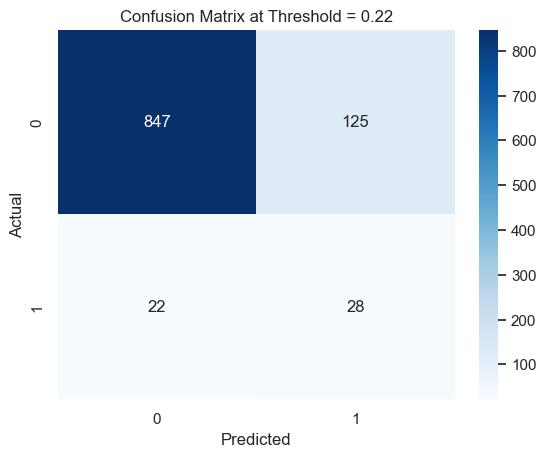

In [127]:
# Apply the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)

# Classification report and confusion matrix
print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix at Threshold = {best_threshold:.2f}")
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Conclusions After Threshold Tuning (HistGradientBoostingClassifier on Oversampled Data)

---

#### Classification Report

- **Class 0 (No Stroke):**  
  - **Precision:** 0.97 — Excellent; most predicted non-stroke cases were correct.  
  - **Recall:** 0.87 — A drop compared to the default threshold (0.96), indicating more false positives.  
  - **F1-Score:** 0.92 — Still strong overall, but slightly impacted by reduced recall.

- **Class 1 (Stroke):**  
  - **Precision:** 0.18 — Low; many predicted stroke cases were incorrect. This dropped from 0.24 at the default threshold.  
  - **Recall:** 0.56 — A significant improvement over the default threshold (0.26), capturing over half of actual stroke cases.  
  - **F1-Score:** 0.28 — Marginally better than the default (0.25), indicating a modest net benefit in stroke prediction.

---

#### Confusion Matrix Comparison

| **Threshold** (Default 0.5) | **Predicted: No Stroke** | **Predicted: Stroke** |
|-----------------------------|--------------------------|------------------------|
| **Actual: No Stroke**       | 930 (True Negative)      | 42 (False Positive)    |
| **Actual: Stroke**          | 37 (False Negative)      | 13 (True Positive)     |

<br />

| **Threshold** (Best 0.22)   | **Predicted: No Stroke** | **Predicted: Stroke** |
|-----------------------------|--------------------------|------------------------|
| **Actual: No Stroke**       | 847 (True Negative)      | 125 (False Positive)   |
| **Actual: Stroke**          | 22 (False Negative)      | 28 (True Positive)     |

- **TN dropped**: more non-stroke cases were misclassified as stroke  
- **FP increased**: more false alarms for stroke  
- **FN dropped**: fewer missed stroke cases  
- **TP increased**: better at identifying stroke cases

---

#### Summary

- **Threshold tuning to 0.22** significantly improves **recall for stroke cases**, meaning more actual stroke cases are correctly identified.
- This comes at the cost of **precision**, especially for class 1 — the model now raises more false alarms.
- The model still favors class 0 due to its dominance in the dataset, but the tuned threshold allows for a better balance between sensitivity and specificity.
- **Despite improvements, the model remains weak at detecting stroke cases**, and only about **half of the predicted stroke cases are correct** — highlighting the challenge of working with imbalanced clinical data.

# 15. Final Model and Saving

In [132]:
# Retrain the model on the full (oversampled) training dataset
final_model = HistGradientBoostingClassifier(random_state=42)
final_model.fit(X_train, y_train)  # X_train and y_train are from the oversampled dataset

model_package = {
    "model": final_model,
    "threshold": 0.22  # your best threshold
}

# Get the current notebook directory
notebook_dir = os.getcwd()

# Define project root relative to notebook (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Construct full path to models folder in project root
models_dir = os.path.join(project_root, "models")

# Make sure it exists
os.makedirs(models_dir, exist_ok=True)

# Full path for saving the model
model_path = os.path.join(models_dir, "final_model_histgbc.joblib")

# Save model
joblib.dump(model_package, model_path)

print("Model and threshold have been retrained and saved as 'final_model_histgbc.joblib'")
print(f"Model saved to {model_path}")

Model and threshold have been retrained and saved as 'final_model_histgbc.joblib'
Model saved to /Users/adabyt/Documents/data_science_projects/stroke-prediction-ml/models/final_model_histgbc.joblib


# 16. Loading and Testing the Final Model


Classification Report at Threshold = 0.22:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.18      0.56      0.28        50

    accuracy                           0.86      1022
   macro avg       0.58      0.72      0.60      1022
weighted avg       0.94      0.86      0.89      1022


Confusion Matrix:


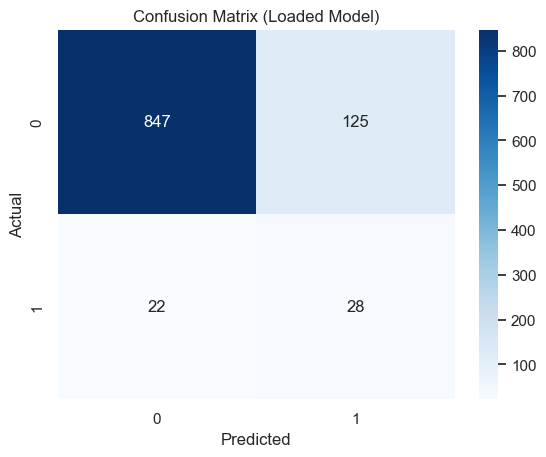


ROC AUC Score: 0.8179


In [134]:
# Load the model + threshold
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
models_dir = os.path.join(project_root, "models")
model_path = os.path.join(models_dir, "final_model_histgbc.joblib")

loaded_package = joblib.load(model_path)
loaded_model = loaded_package["model"]
best_threshold = loaded_package["threshold"]

# Predict with custom threshold
y_probs = loaded_model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= best_threshold).astype(int)

# Classification report
print("\nClassification Report at Threshold = 0.22:")
print(classification_report(y_test, y_pred))


print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Loaded Model)")
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"\nROC AUC Score: {roc_auc:.4f}")

### Figure 16a: ROC Curve for Final Model

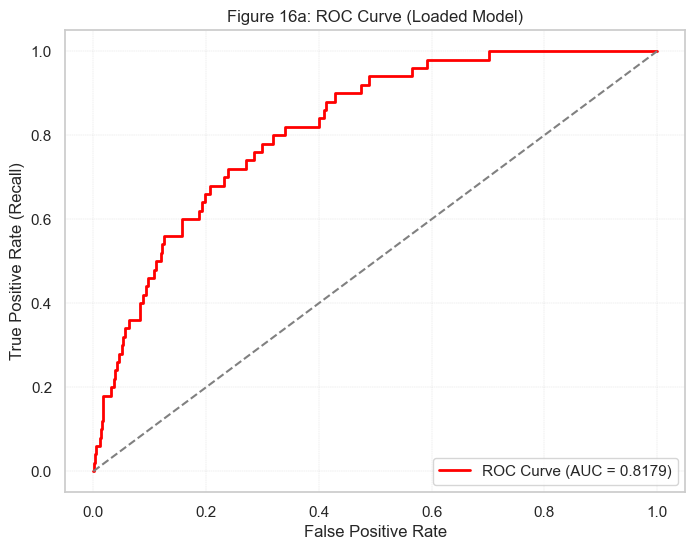

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Figure 16a: ROC Curve (Loaded Model)')
plt.legend(loc='lower right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

### Figure 16b: Precision-Recall Curve for Final Model

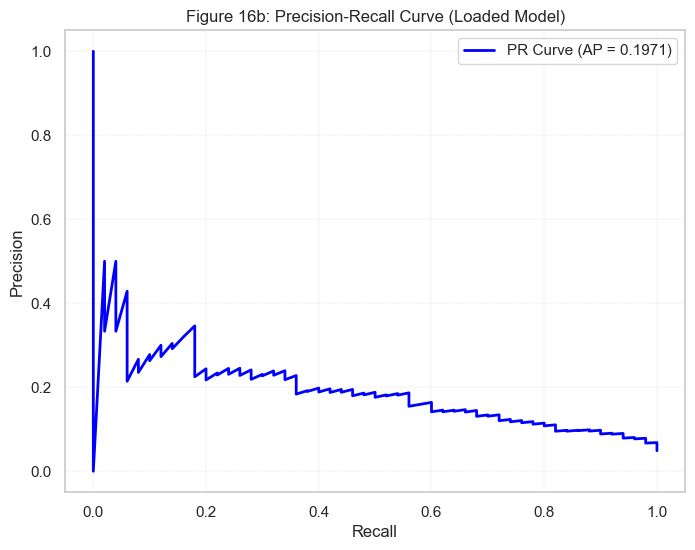

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 16b: Precision-Recall Curve (Loaded Model)')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.3, color='gray', alpha=0.3)
plt.show()

# 17. Final Conclusions

Throughout this project, we tackled the challenge of predicting stroke occurrences from an **imbalanced medical dataset**, where the majority of samples belong to the "no stroke" class. This imbalance created difficulties for most classifiers in correctly identifying stroke cases (class 1), which are rare but critically important.

We explored several classification approaches:

- **Logistic Regression**  
- **Random Forest**
- **HistGradientBoostingClassifier**
- **LightGBM**

Each model was tested on:
- The **original, imbalanced dataset**
- A **randomly oversampled dataset** (where minority stroke cases were duplicated)

Despite class 1 predictions remaining weak overall, we found that:

- **HistGradientBoostingClassifier trained on the oversampled dataset** produced the best balance between **precision** and **recall** for stroke cases.
- It also achieved the **highest F1-score** for class 1 among all tested models, making it the most suitable candidate for further optimisation.

To push the model further, we:
- Tuned the **classification threshold** instead of relying on the default 0.5.
- Identified a **better-performing threshold of 0.22**, which improved the model’s ability to detect stroke cases at the cost of some false positives.

While this did not produce perfect results (precision remained low, and many stroke cases were still missed) it reflects the inherent difficulty of predicting rare events with limited positive samples.

---

### Limitations and Future Work

- We were **unable to use SMOTE**, a more advanced oversampling technique, due to compatibility issues between `imbalanced-learn` and newer versions of `scikit-learn` on macOS. This may be revisited in future versions of the environment.
- Additionally, future improvements could include:
  - **Feature engineering** (e.g., transforming or combining variables)
  - **Domain knowledge integration**
  - **Model ensembling**
  - Exploring **other sampling techniques** like **ADASYN** or **Tomek Links**
  - Acquiring a **larger or more balanced dataset**

---

### Final Thoughts

This project was not just about achieving the best predictive accuracy — it served as a **comprehensive end-to-end exercise in real-world machine learning**. From data preprocessing and EDA to modeling, evaluation, threshold tuning, and model deployment, it demonstrates a complete pipeline that balances technical skill with critical thinking.

The final model — while imperfect — reflects the best trade-offs possible with the tools and data currently available.

*The final model has been saved with its optimised threshold and is ready for deployment or further experimentation.*